In [1]:
import time
from datetime import datetime
import argparse
import json
import threading
import queue
import os

import cv2
import numpy as np
import torch
import redis
import matplotlib.pyplot as plt

from core import support, share_param
from insight_face.modules.tracking.custom_tracking import TrackingMultiCam
from insight_face.utils.database import FaceRecognitionSystem

In [2]:
share_param.sdk_config = support.get_config_yaml("configs/sdk_config.yaml")
share_param.dev_config = support.get_config_yaml("configs/dev_config.yaml")
share_param.facerec_system = FaceRecognitionSystem(share_param.dev_config["DATA"]["photo_path"], share_param.sdk_config )

In [3]:
def check_not_blur(image: np.ndarray):
    if image is None or image.size == 0:
        return False, 0.0

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    imageresize = cv2.resize(image, (112,112))

    # print(imageresize.shape)

    # gray = cv2.cvtColor(imageresize, cv2.COLOR_RGB2GRAY)

    # lap = cv2.Laplacian(imageresize, cv2.CV_64F)

    real_notblur = cv2.Laplacian(imageresize, cv2.CV_64F).var()

    # gray = cv2.cvtColor(lap.copy().astype(np.uint64), cv2.COLOR_RGB2GRAY)

    # bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # cv2.imshow("lap", lap)
    # cv2.imshow("gray", gray)
    # cv2.imshow("bin", bin)
    # cv2.waitKey(0)
    # plt.figure()
    # plt.title("lap")
    # plt.imshow(lap)

    # plt.figure()
    # plt.title("gray")
    # plt.imshow(gray)

    # plt.figure()
    # plt.title("bin")
    # plt.imshow(bin)

    standard_notblur = 300

    threshnotblur = real_notblur/standard_notblur
    print(threshnotblur)

    if threshnotblur < 1.5:
        return False, threshnotblur
    else:
        return True, threshnotblur
    return False, threshnotblur

In [6]:
def illumination(image):
    image = cv2.resize(image, (112,112))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # length of R available  range  of  gray  intensities  excluding  5%  of  the darkest  and  brightest  pixel
    sorted_gray = np.sort(gray.ravel())
    l = len(sorted_gray)
    cut_off_idx = l * 5 // 100
    r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    return np.round(r / 255, 2)

### Check quality
Blur and Straight

2.3068177718135865
Ratio: 0.8387178 0.010823827 0.43585643
0.09957864031948435
Ratio: 0.9091145 0.0033017348 0.62193257
2.3693709124018567
Ratio: 0.8942676 0.16151404 0.49411187
1.517337633623372
Ratio: 0.96349233 0.036831114 0.57937443
1.8027861603812745
Ratio: 0.89670044 0.2518318 0.48028934
1.0704849492687292
Ratio: 1.0343138 0.031975985 0.55745196
0.09532864712800135
Ratio: 0.96276647 0.008899131 0.54700035
1.7400834603766921
Ratio: 0.95213795 0.005572294 0.584722
1.3306976138413609
Ratio: 0.58500004 0.372979 0.6774804
0.9804198154445521
Ratio: 0.9799361 0.05491274 0.6718776
0.025050016534391536
Ratio: 0.9792457 0.01179759 0.5441889
1.1185643652799249
Ratio: 0.8302732 0.25015643 0.5090493
2.252346527185757
Ratio: 1.042287 0.006558 0.41134727
0.7492809505457645
Ratio: 0.96214265 0.2765778 0.47544894
0.015659196406333002
Ratio: 1.0110068 0.0067090704 0.5374827
1.986148699809381
Ratio: 0.96793693 0.038225383 0.48863006
1.8542992031616359
Ratio: 0.9717746 0.004493317 0.4221822
1.866446

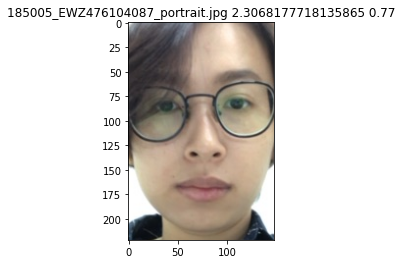

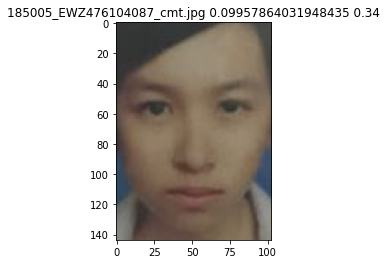

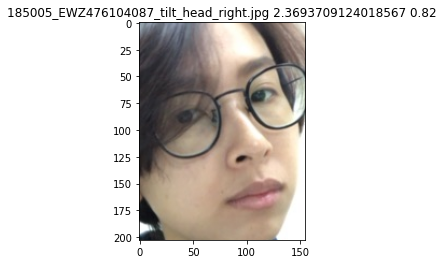

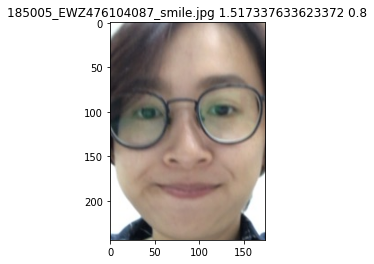

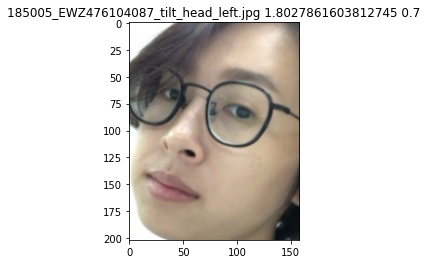

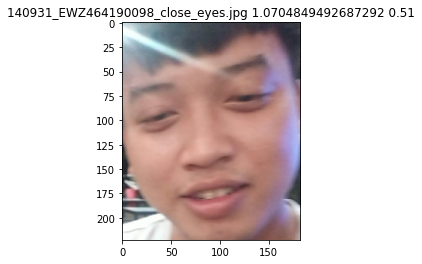

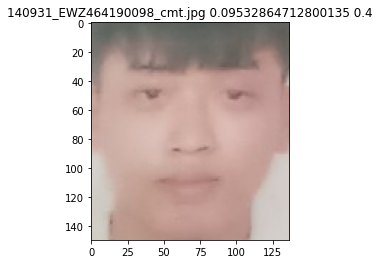

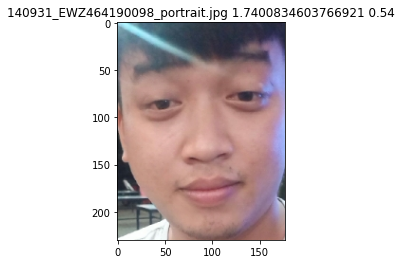

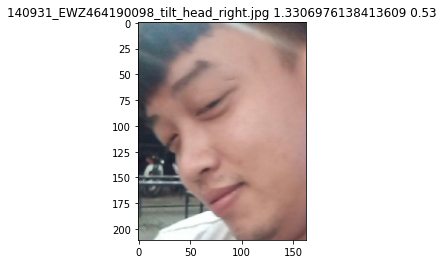

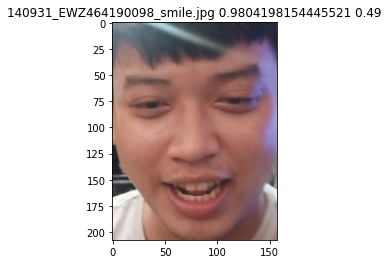

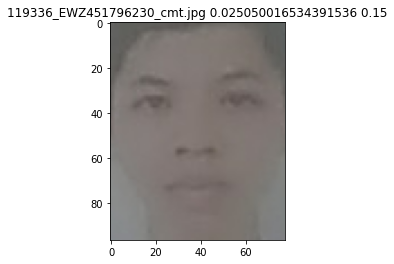

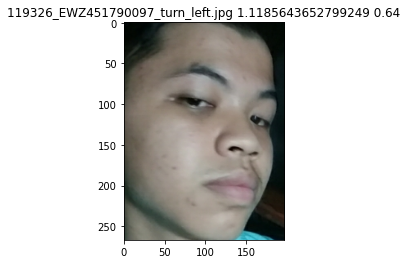

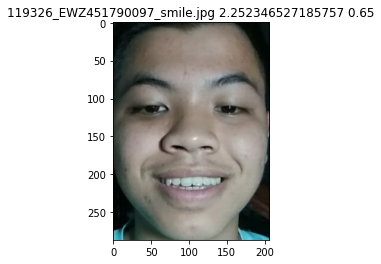

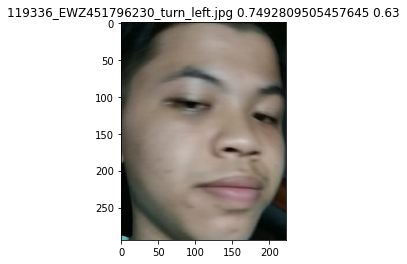

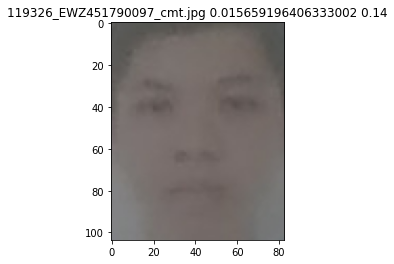

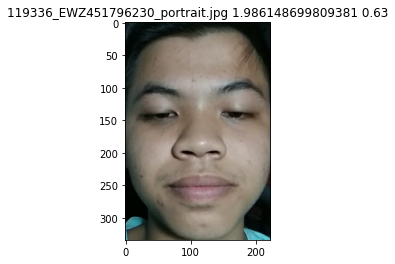

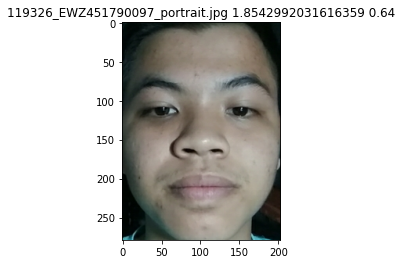

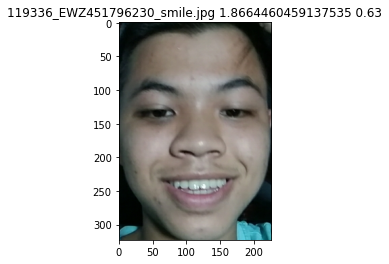

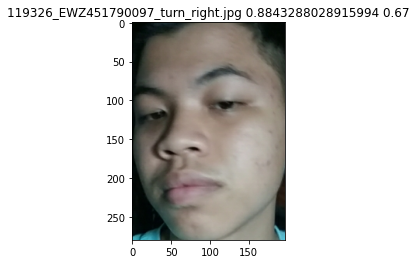

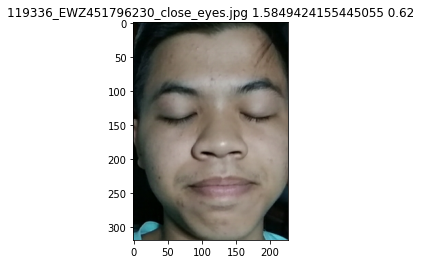

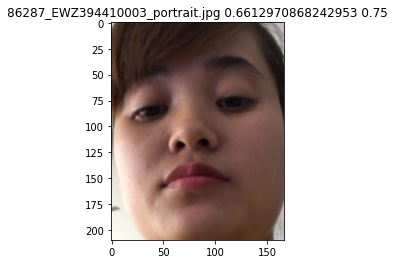

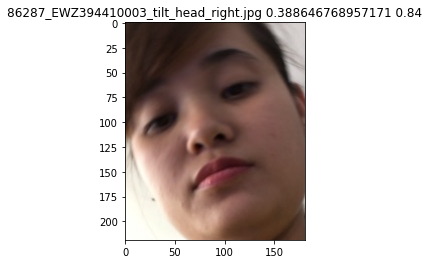

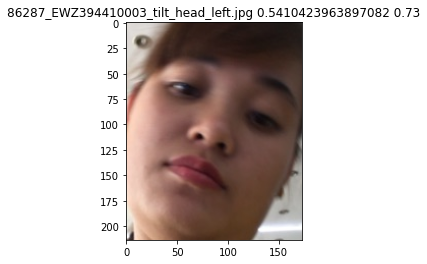

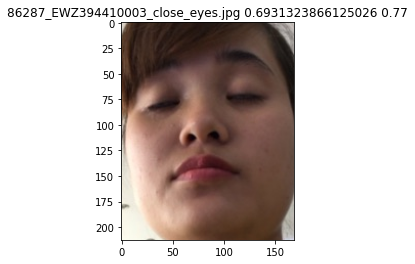

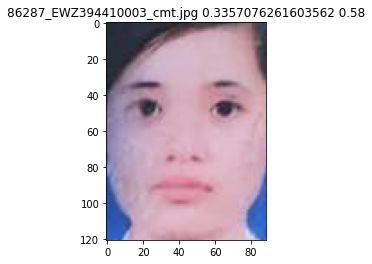

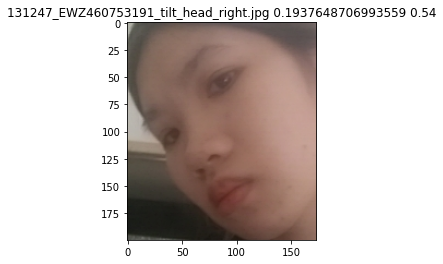

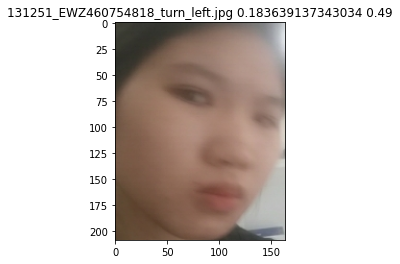

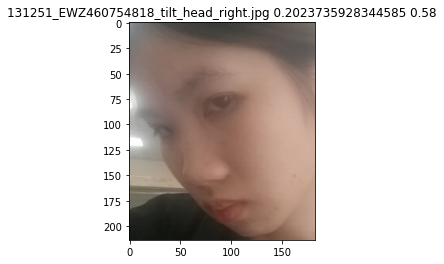

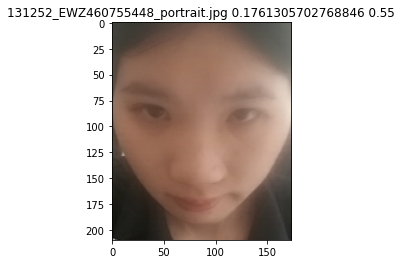

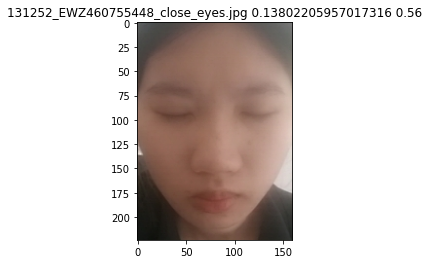

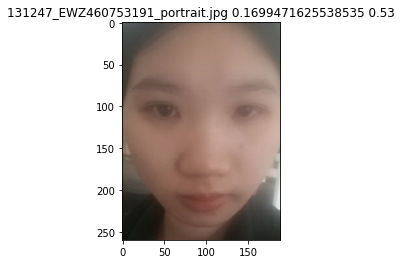

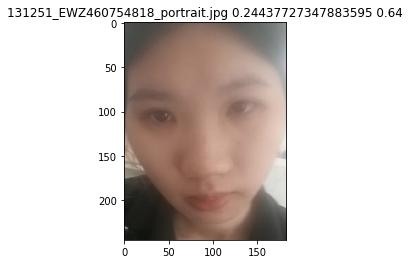

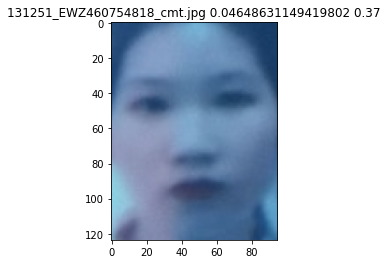

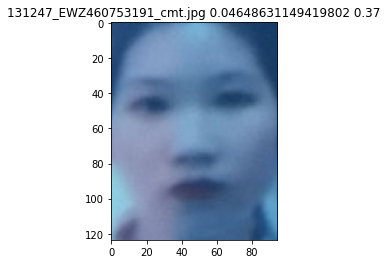

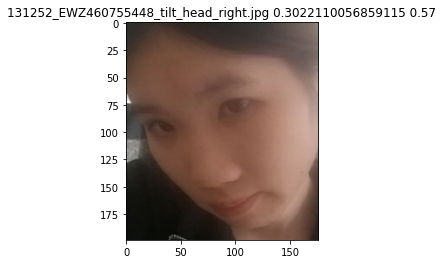

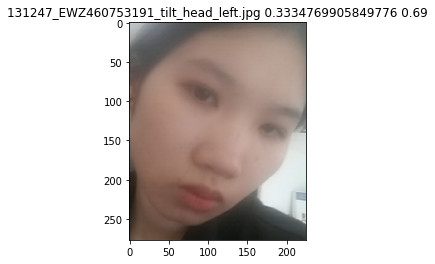

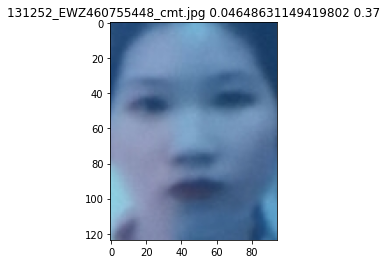

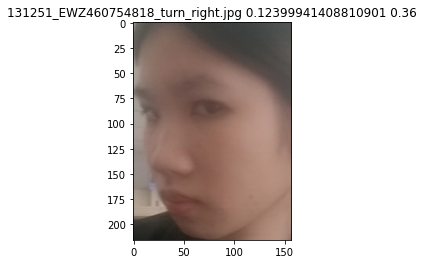

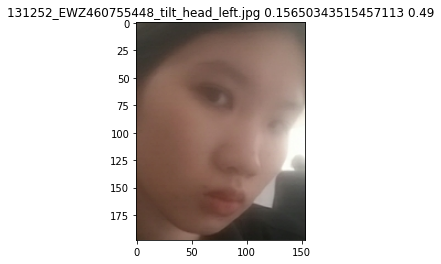

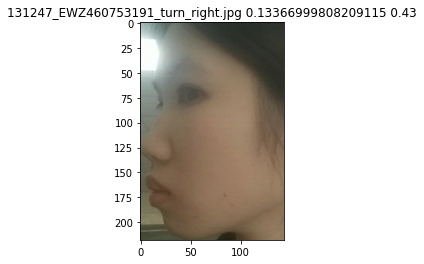

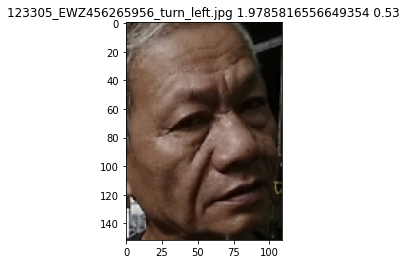

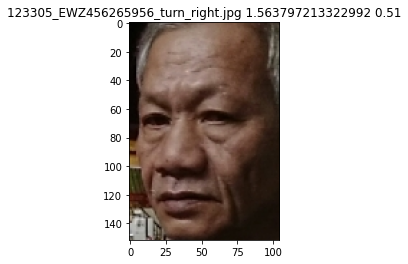

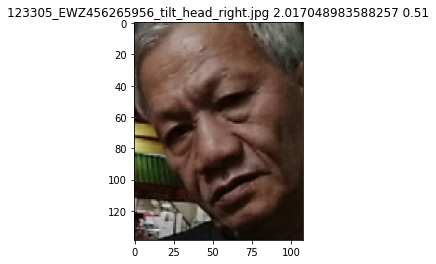

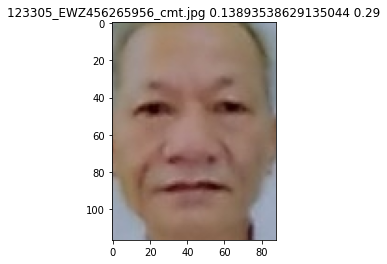

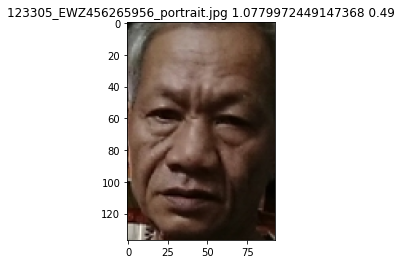

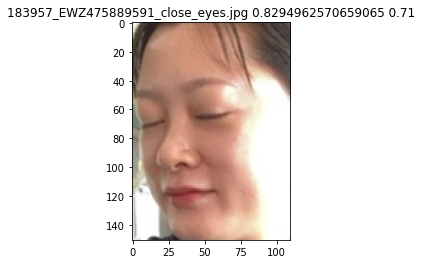

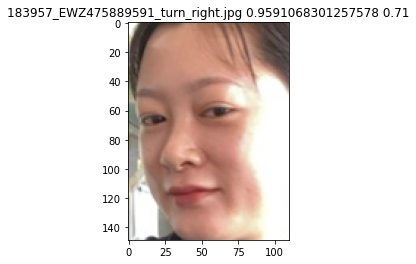

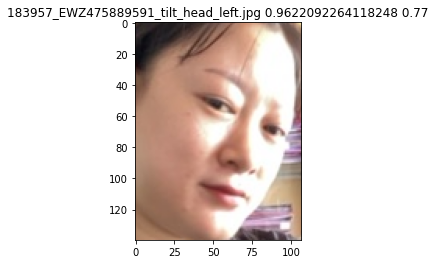

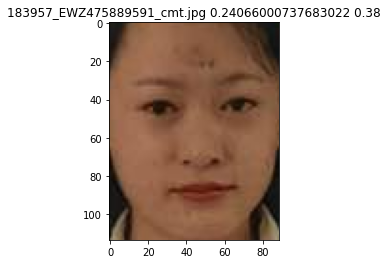

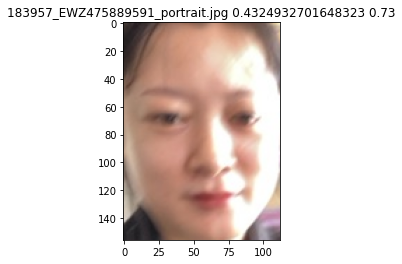

In [7]:

count = 0
for root, dirs, files in os.walk("/mnt/LINUXDATA/Source/data/matched_faces", topdown=False):
    # print(root)
    for name in files:
        count+=1
        if count>100:
            break
        # print(name)
        # if name != "focus_02550.jpg":
        #     continue
        path = os.path.join(root, name)
        rgb = cv2.imread(path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        bboxes, landmarks = share_param.facerec_system.sdk.detect_faces(rgb)
        # print(bboxes)
        # print(landmarks)
        for bbox, landmark in zip(bboxes, landmarks):
            faceSize = float((bbox[3]-bbox[1])*(bbox[2]-bbox[0]))
            faceAlign = share_param.facerec_system.sdk.align_face(rgb, landmark)
            faceCrop = rgb[int(bbox[1]):int(bbox[3]),
                                    int(bbox[0]):int(bbox[2])]

            if faceCrop.shape[0] < 50 or faceCrop.shape[1] < 50:
                continue
            isNotBlur, threshnotblur = check_not_blur(faceCrop)
            illuminate = illumination(faceCrop)
            # isNotBlur, threshnotblur = share_param.facerec_system.sdk.evaluter.detect_blur_fft(faceAlign, size=30)
            isStraightFace = share_param.facerec_system.sdk.evaluter.check_straight_face(rgb, landmark)
            # print("Not blur:", isNotBlur)
            # print("Straight:", isStraightFace)
            cnts = landmark.reshape(5,2, order='F')
            # for point in cnts:
            #     cv2.drawMarker(rgb, tuple(point), color=(0,255,0), markerType=cv2.MARKER_CROSS, markerSize=8, thickness=1)
            plt.figure()
            plt.title(f"{name} {threshnotblur} {illuminate}")
            plt.imshow(faceCrop)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('datalab/images/20210507145554353919.jpg')
# img = cv2.resize(img, (224,224))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [ ]:

minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

#Size Parameter
lower_threshold = 100
upper_threshold = 200

bboxes, points = share_param.facerec_system.sdk.detect_faces(img)

print(bboxes, points)


In [ ]:
def illumination(gray):
    # length of R available  range  of  gray  intensities  excluding  5%  of  the darkest  and  brightest  pixel
    sorted_gray = np.sort(gray.ravel())
    l = len(sorted_gray)
    cut_off_idx = l * 5 // 100
    r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    return np.round(r / 255, 2)


In [ ]:
illumination(gray)

In [ ]:
def get_contour(pts):
    return np.array([[pts[i], pts[5 + i]] for i in  [0, 1, 4, 3]], np.int32).reshape((-1,1,2))
def get_mask(image, contour):
    mask = np.zeros(image.shape[0:2],dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    return mask

In [ ]:
def sharpness(img, landmark):
    contour = get_contour(landmark)
    mask = get_mask(img, contour) #1-channel mask
    # plt.imshow(mask)
    mask = np.stack((mask,)*3, axis=-1) #3-channel mask
    mask[mask == 255] = 1 # convert 0 and 255 to 0 and 1
    laplacian = cv2.Laplacian(img,cv2.CV_64F)
    # print(laplacian)
    # print(laplacian.var())
    edges = laplacian[mask.astype(bool)]
    return np.round(edges.var() / 255 , 2)

plt.imshow(img)
sharpness(img, points[0])

In [ ]:
from skimage.feature import hog

def symmetry(img, landmark, bounding_box):
    x1, y1, x2, y2 = int(min(bounding_box[0], min(landmark[:5]))), \
        int(min(bounding_box[1], min(landmark[5:]))), \
        int(max(bounding_box[2], max(landmark[:5]))), \
        int(max(bounding_box[3], max(landmark[5:])))
    
    landmark = np.array([[landmark[i], landmark[5 + i]] for i in  range(5)], np.int32).reshape((-1,1,2))
    contour = landmark[:, 0] - [[x1, y1]]
    
    face = img[y1: y2, x1: x2].copy()
    face_flip = cv2.flip(face, 1)
    
    fd_face, hog_face = hog(face, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    fd_flip, hog_flip = hog(face_flip, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    
    
    d = np.zeros(len(contour))
    for i in range(len(d)):
        d[i] = min(hog_face[contour[i, 1], contour[i, 0]], hog_flip[contour[i, 1], contour[i, 0]])
    
    return np.average(d)

In [ ]:
symmetry(img, points[0], bboxes[0])

In [ ]:
plt.figure()
for root, dirs, files in os.walk("datalab/images/", topdown=False):
    # print(root)
    for name in files:
        path = os.path.join(root, name)
        img = cv2.imread(path)
        # img = cv2.resize(img, (224,224))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bboxes, points = share_param.facerec_system.sdk.detect_faces(img)
        if len(bboxes) == 0:
            continue
        # print(bboxes)
        # print(points)
        # print("illumination",illumination(gray))
        # print("sharpness",sharpness(img, points[0]))
        # print("symmetry", symmetry(img, points[0], bboxes[0]))

        cv2.rectangle(img, (int(bboxes[0][0]), int(bboxes[0][1])), (int(bboxes[0][2]), int(bboxes[0][3])), (0, 255, 0), 2)
        plt.figure()
        strInfo = f"{illumination(gray)} {sharpness(img, points[0])} {symmetry(img, points[0], bboxes[0])}"
        plt.title(strInfo)
        plt.imshow(img)



In [ ]:
sharpness 0.27
symmetry 0.11464042663574218